In [1]:
import array

In [2]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
import graphlab
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

# Make sure that caffe is on the python path:
caffe_root = '/Users/voelunteer/Project/caffe/'  # this file is expected to be in {caffe_root}/examples
import sys
sys.path.insert(0, caffe_root + 'python')
import caffe

/Users/voelunteer/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


This non-commercial license of GraphLab Create is assigned to voelunteer@gmail.com and will expire on December 23, 2016. For commercial licensing options, visit https://dato.com/buy/.


2016-04-25 21:48:22,836 [INFO] graphlab.cython.cy_server, 176: GraphLab Create v1.8.5 started. Logging: /tmp/graphlab_server_1461635301.log


In [3]:
# Download pre-trained googlenet model
# import os
# if os.path.isfile('models/bvlc_googlenet/bvlc_googlenet.caffemodel'):
#     print 'CaffeNet found.'
# else:
#     print 'Downloading pre-trained CaffeNet model...'
#    !/Users/voelunteer/Project/caffe/scripts/download_model_binary.py /Users/voelunteer/Project/caffe/models/bvlc_googlenet
import os
if os.path.isfile(caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'):
    print 'CaffeNet found.'
else:
    print 'Downloading pre-trained CaffeNet model...'
    !../scripts/download_model_binary.py ../models/bvlc_reference_caffenet

CaffeNet found.


In [4]:
caffe.set_mode_cpu()

model_def = caffe_root + 'models/bvlc_reference_caffenet/deploy.prototxt'
model_weights = caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

In [5]:
# load the mean ImageNet image (as distributed with Caffe) for subtraction
mu = np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
#create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

In [6]:
net.blobs['data'].reshape(1,        # batch size
                          3,         # 3-channel (BGR) images
                          227, 227)  # image size is 227x227

In [7]:
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

data	(1, 3, 227, 227)
conv1	(10, 96, 55, 55)
pool1	(10, 96, 27, 27)
norm1	(10, 96, 27, 27)
conv2	(10, 256, 27, 27)
pool2	(10, 256, 13, 13)
norm2	(10, 256, 13, 13)
conv3	(10, 384, 13, 13)
conv4	(10, 384, 13, 13)
conv5	(10, 256, 13, 13)
pool5	(10, 256, 6, 6)
fc6	(10, 4096)
fc7	(10, 4096)
fc8	(10, 1000)
prob	(10, 1000)


In [8]:
train_imgs = graphlab.image_analysis.load_images('../data/imgs/train')

Read 1723 images in 5.00021 secs	speed: 344.585 file/sec

Read 3409 images in 10.0019 secs	speed: 337.085 file/sec

Read 5080 images in 15.0096 secs	speed: 333.687 file/sec

Unsupported image format. Supported formats are JPG and PNG	 file: /Users/voelunteer/Project/Kaggle/StateFarm/data/imgs/train/.DS_Store

Read 6732 images in 20.0109 secs	speed: 330.311 file/sec

Read 8394 images in 25.0131 secs	speed: 332.258 file/sec

Unsupported image format. Supported formats are JPG and PNG	 file: /Users/voelunteer/Project/Kaggle/StateFarm/data/imgs/train/c0/.DS_Store

Read 10052 images in 30.0146 secs	speed: 331.497 file/sec

Read 11720 images in 35.018 secs	speed: 333.375 file/sec

Read 13415 images in 40.0181 secs	speed: 338.992 file/sec

Unsupported image format. Supported formats are JPG and PNG	 file: /Users/voelunteer/Project/Kaggle/StateFarm/data/imgs/train/c1/.DS_Store

Read 15113 images in 45.02 secs	speed: 339.476 file/sec

Read 16761 images in 50.0209 secs	speed: 329.538 file/sec

Read 18448 images in 55.0285 secs	speed: 336.89 file/sec

Read 20138 images in 60.0298 secs	speed: 337.911 file/sec

Read 21812 images in 65.0307 secs	speed: 334.74 file/sec

In [9]:
# test_imgs = graphlab.image_analysis.load_images('../data/imgs/test')

In [12]:
train_imgs['label'] = train_imgs['path'].apply(lambda x: x.split('/')[-2]) 
test_imgs['label'] = None

NameError: name 'test_imgs' is not defined

In [14]:
train_imgs['img_name'] = train_imgs['path'].apply(lambda x: x.split('/')[-1]) 
#test_imgs['img_name'] = test_imgs['path'].apply(lambda x: x.split('/')[-1]) 

In [15]:
def is_number(s):
    try:
        n=str(float(s))
        if n == "nan" or n=="inf" or n=="-inf" : return False
    except ValueError:
        try:
            complex(s) # for complex
        except ValueError:
            return False
    return True

In [11]:
def feature_extraction(path, node):
    image = caffe.io.load_image(path)
    net.blobs['data'].data[...] = transformer.preprocess('data', image)
    net.forward()
    feature_lists = net.blobs[node].data[0]
    feature = array.array('d', [item for list in feature_lists for sublist in list for item in sublist if is_number(item)])
    return feature

In [10]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

In [225]:
features = []
for img_file in train_imgs:
    features.append(feature_extraction(img_file['path'], 'conv5'))

train_img_conv5 = graphlab.SFrame({'img_name': train_imgs['img_name'], 'conv5': features})
train_imgs = train_img.join(train_img_conv5, on='img_name')




In [226]:
train_imgs.save('../output/train_imgs_conv5.csv')

path,image,label,img_name,conv5
/Users/voelunteer/Project/Kaggle/StateFarm/dat ...,Height: 480 Width: 640,c6,img_52659.jpg,"[0.0, 0.0, 0.0, 0.0, 0.0,0.0, 0.0, 13.992606163, ..."
/Users/voelunteer/Project/Kaggle/StateFarm/dat ...,Height: 480 Width: 640,c3,img_40278.jpg,"[0.0, 0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, ..."
/Users/voelunteer/Project/Kaggle/StateFarm/dat ...,Height: 480 Width: 640,c3,img_44764.jpg,"[0.0, 4.00793409348, 0.0,0.0, 0.0, 0.0, 0.0, 0.0, ..."
/Users/voelunteer/Project/Kaggle/StateFarm/dat ...,Height: 480 Width: 640,c5,img_82112.jpg,"[0.0, 0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, 0.0, 0.0, ..."
/Users/voelunteer/Project/Kaggle/StateFarm/dat ...,Height: 480 Width: 640,c6,img_17196.jpg,"[0.0, 0.0, 0.0, 0.0, 0.0,0.0, 18.5250263214, ..."
/Users/voelunteer/Project/Kaggle/StateFarm/dat ...,Height: 480 Width: 640,c0,img_100312.jpg,"[0.0, 0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, ..."
/Users/voelunteer/Project/Kaggle/StateFarm/dat ...,Height: 480 Width: 640,c5,img_28478.jpg,"[0.0, 0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, 0.0, ..."
/Users/voelunteer/Project/Kaggle/StateFarm/dat ...,Height: 480 Width: 640,c8,img_56891.jpg,"[0.0, 1.91837847233, 0.0,0.0, 0.0, 0.0, 0.0, 0.0, ..."
/Users/voelunteer/Project/Kaggle/StateFarm/dat ...,Height: 480 Width: 640,c0,img_95056.jpg,"[0.0, 14.4701318741, 0.0,0.0, 0.0, 0.0, 0.0, 0.0, ..."
/Users/voelunteer/Project/Kaggle/StateFarm/dat ...,Height: 480 Width: 640,c4,img_23123.jpg,"[0.0, 0.0, 0.0, 0.0, 0.0,0.0, 3.87563991547, 0.0, ..."


In [ ]:
features = []
for img_file in test_imgs:
    features.append(feature_extraction(img_file['path'], 'conv5'))

test_img_conv5 = graphlab.SFrame({'img_name': test_imgs['img_name'], 'conv5': features})
test_imgs = test_imgs.join(train_img_conv5, on='img_name')

In [ ]:
test_imgs.save('../output/test_imgs_conv5.csv')

In [18]:
train_imgs[1]['path']

'/Users/voelunteer/Project/Kaggle/StateFarm/data/imgs/train/c3/img_40278.jpg'

In [19]:
image = caffe.io.load_image('/Users/voelunteer/Project/Kaggle/StateFarm/data/imgs/train/c3/img_40278.jpg')

In [33]:
net.blobs['data'].data[...] = transformer.preprocess('data', image)
net.forward()
feature_lists = net.blobs['norm1'].data[0]

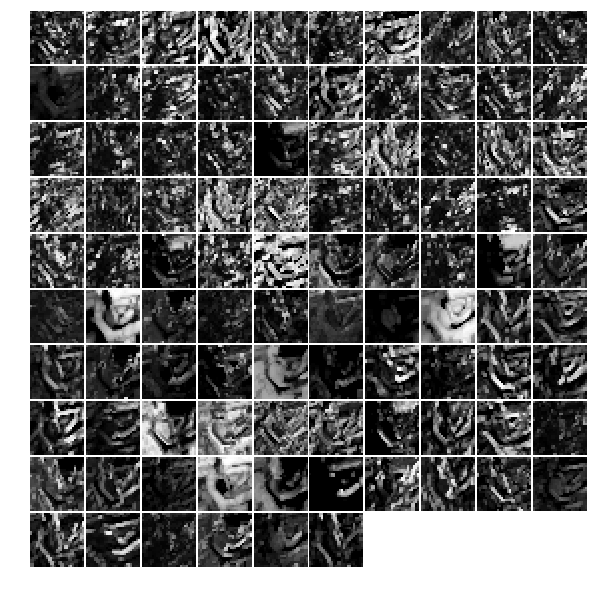

In [34]:
vis_square(feature_lists)